In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# 定义计算不确定度的函数
def calculate_uncertainty(fisher_matrix):
    try:
        # 计算 Fisher 矩阵的逆
        inverse_matrix = np.linalg.inv(fisher_matrix)
        
        # 提取对角元素并计算其平方根
        uncertainties = np.sqrt(np.diag(inverse_matrix))
        return uncertainties
    except np.linalg.LinAlgError:
        print("该矩阵是奇异矩阵，没有逆矩阵。")
        return None

# 初始化存储不确定度结果的字典
uncertainty_results = {}

# 处理每个.pkl文件
file_paths = ["./R_ET_1_0.pkl", "./R_ET_2_0.pkl", "./R_ET_3_0.pkl"]

In [2]:
PARAM_NAMES = [
    "Right Ascension (Ra)",  
    "Declination (Dec)", 
    "Time Delay (t)", 
    "Luminosity Distance (Dist)", 
    "Polarization Angle (Pol)",
    "Mass (M)", 
    "Inclination Angle (iota)",  
    "Mass Ratio (eta)", 
    "Initial Phase (phi)" 
]

In [3]:
for i, file_path in enumerate(file_paths, start=1):
    # 打开并读取.pkl文件中的数据
    with open(file_path, 'rb') as f:
        A, B, C, D = pickle.load(f)
    
    # 计算不确定度
    uncertainties = calculate_uncertainty(B)
    
    if uncertainties is not None:
        # 将结果存入字典
        detector_name = f"ET_{i}"
        uncertainty_results[detector_name] = uncertainties

# 查看不确定度结果
print("\n不确定度结果:")
for detector, uncertainties in uncertainty_results.items():
    print(f"{detector}: {uncertainties}")


不确定度结果:
ET_1: [3.01659021e+02 2.96507651e+02 7.18885132e-03 4.84108275e-02
 1.82924728e+02 5.83035231e+02 3.59299998e+01 6.99619961e-03
 4.78536992e+02]
ET_2: [1.02549592e+02 1.00803504e+02 2.43212856e-03 1.64066841e-02
 3.37255517e+01 1.82243127e+02 2.39908158e+02 2.36704919e-03
 1.85607728e+02]
ET_3: [1.04955315e+02 1.03376251e+02 2.83218427e-03 1.99670148e-02
 3.53818033e+01 2.47798943e+01 1.81579353e+02 2.75338885e-03
 3.47761913e+02]


In [4]:
# 创建 DataFrame 存储不确定度
df = pd.DataFrame(uncertainty_results, index=PARAM_NAMES)
df.index.name = "Parameter"

# 打印 DataFrame 结果
print("\n不确定度结果 DataFrame:")
display(df)


不确定度结果 DataFrame:


,ET_1,ET_2,ET_3
Parameter,,,
Right Ascension (Ra),301.659021,102.549592,104.955315
Declination (Dec),296.507651,100.803504,103.376251
Time Delay (t),0.007189,0.002432,0.002832
Luminosity Distance (Dist),0.048411,0.016407,0.019967
Polarization Angle (Pol),182.924728,33.725552,35.381803
Mass (M),583.035231,182.243127,24.779894
Inclination Angle (iota),35.930000,239.908158,181.579353
Mass Ratio (eta),0.006996,0.002367,0.002753
Initial Phase (phi),478.536992,185.607728,347.761913


In [5]:
# 保存结果为 CSV 文件
output_file = "uncertainties.csv"
df.to_csv(output_file)

print(f"结果已保存至 {output_file}")

结果已保存至 uncertainties.csv


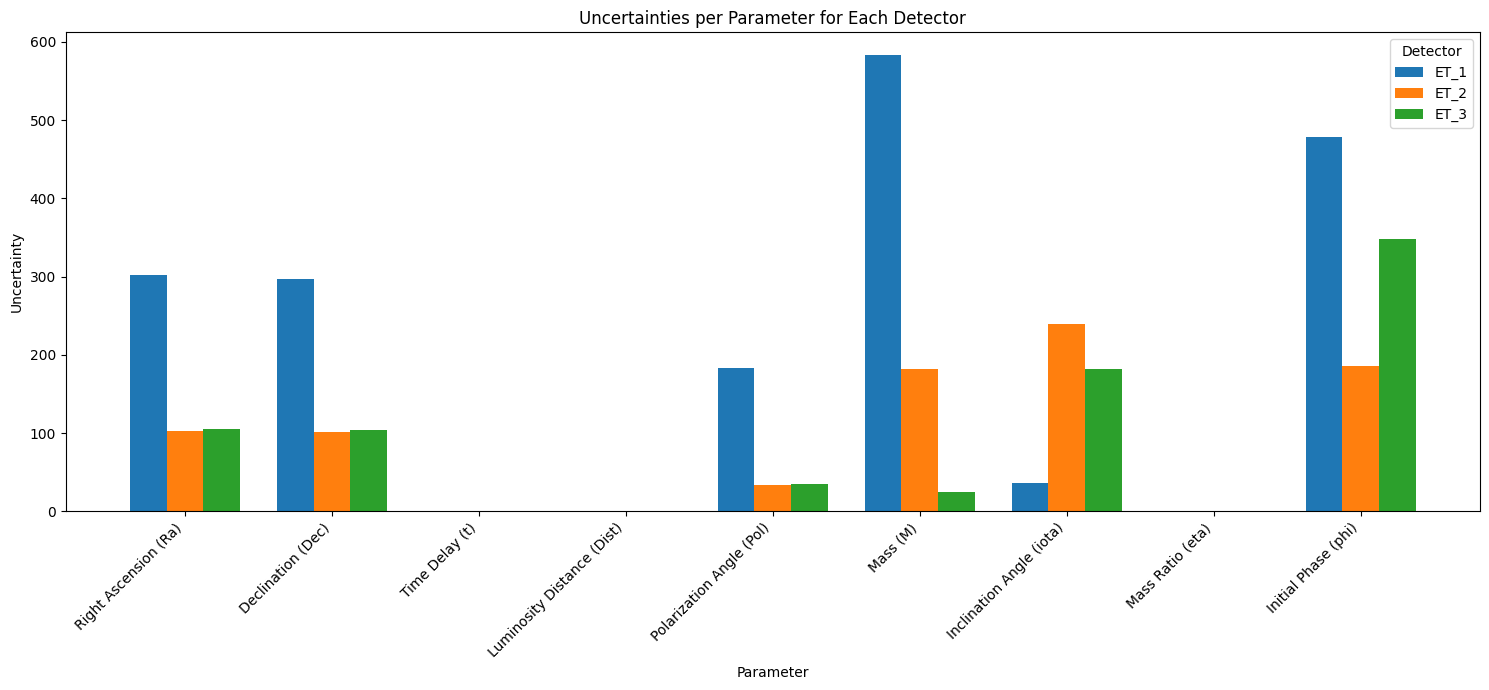

In [6]:
# 可视化不确定度结果
bar_width = 0.25
x = np.arange(len(PARAM_NAMES))

plt.figure(figsize=(15, 7))

# 绘制每个检测器的柱状图
for i, detector in enumerate(df.columns):
    plt.bar(x + i * bar_width, df[detector], width=bar_width, label=detector)

# 设置坐标轴和标题
plt.xticks(x + bar_width, PARAM_NAMES, rotation=45, ha='right')
plt.xlabel('Parameter')
plt.ylabel('Uncertainty')
plt.title('Uncertainties per Parameter for Each Detector')
plt.legend(title='Detector')

plt.tight_layout()
plt.show()